裂縫固定水平線, time-dependent heat equation, f=1, g=0.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 0.25  

N_f = 1000       
N_b_outer = 1000
N_b_crack = 1000
N_ic = 1000
N_ic_out = 1000
N_ic_crack = 1000
epochs = 10000
lambda_bc = 1.0
lambda_ic = 1.0
lambda_zz = 1.0
lambda_zz3 = 1.0


Device: cpu


In [40]:
# MLP 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) #????
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)
        return z

# model (input: x,y,phi,t) 
layers = [4, 64, 64, 1]
model = MLP(layers).to(device)  
# optimizer
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")    

In [41]:
# functions

def compute_phi_and_derivs(x, y, t):
    x = x.view(-1, 1).to(device)
    y = y.view(-1, 1).to(device)
    t = t.view(-1, 1).to(device)
    angle = torch.tensor(np.pi * 0.0 / 4.0, dtype=x.dtype, device=x.device)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    inside = r - (x * torch.cos(angle) + y * torch.sin(angle))
    phi = torch.sqrt(0.5 * inside)
    sqrt_term = torch.sqrt(inside)
    phi_x = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (x / r - torch.cos(angle))) / (4.0 * sqrt_term)
    phi_y = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (y / r - torch.sin(angle))) / (4.0 * sqrt_term)

    return phi, phi_x, phi_y    

def partials_U_wrt_inputs(model, x, y, phi, t):
    x = x.view(-1,1)
    y = y.view(-1,1)
    phi = phi.view(-1,1)
    t = t.view(-1,1)

    inp = torch.cat([x, y, phi, t], dim=1).to(device)
    inp.requires_grad_(True)
    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U),
                                create_graph=True, retain_graph=True)[0]  # (N,4)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]   
    U_t = grads[:,3:4]   
    return U, inp, U_x, U_y, U_z, U_t

def second_partials_U(model, inp, U_x, U_y, U_z):
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    U_xz = grad_Ux[:,2:3]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

def compute_residual_time(model, x, y, t):
    x_in = x.clone().detach().requires_grad_(True).to(device)
    y_in = y.clone().detach().requires_grad_(True).to(device)
    t_in = t.clone().detach().requires_grad_(True).to(device)

    phi, phi_x, phi_y = compute_phi_and_derivs(x_in, y_in, t_in)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x_in, y_in, phi, t_in)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)

    r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    #r = torch.sqrt(x**2 + y**2)
    laplace_U = U_xx + U_yy
    lap = laplace_U + 2.0 * (U_xz * phi_x + U_yz * phi_y) + (1/(4*r)) * U_zz

    # ut =  U_t
    ut =  U_t
    residual = ut - lap - 1.0
    return residual, U, U_zz, U_xz, U_yz

# compute tip constraint 
def compute_zz_uN(model, t): # 在原點 U_xz=0, U_yz=0, U_zz=0 
    if not torch.is_tensor(t):
        t = torch.tensor([[t]], dtype=torch.float64, device=device)
    else:
        t = t.view(-1,1).to(dtype=torch.float64, device=device)

    x = torch.zeros_like(t)
    y = torch.zeros_like(t)

    phi, _, _ = compute_phi_and_derivs(x, y, t)
    _, inp, _, _, U_z, _ = partials_U_wrt_inputs(model, x, y, phi, t)

    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_zz = grad_Uz[:,2:3]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]
    return torch.mean(U_zz**2 + U_xz**2 + U_yz**2)   


def compute_xyz_uN(model,x, y, t): # 在線上 U_xz=0, U_yz=0 
    if not torch.is_tensor(t):
        t = torch.tensor([[t]], dtype=torch.float64, device=device)
    else:
        t = t.view(-1,1).to(dtype=torch.float64, device=device)
    phi, phi_x, phi_y = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]

    return torch.mean(U_xz**2+U_yz**2)   

# sampling
def sample_collocation(N): 
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN 
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN 
    t = torch.rand(N*2,1) * (T_MAX - T_MIN) + T_MIN 
    # 點到 y=0 的距離 : |y|
    dist_to_crack = torch.abs(y)
    # mask 
    mask_crack = (dist_to_crack < 1e-8) 
    x, y, t = x[~mask_crack][:N], y[~mask_crack][:N], t[~mask_crack][:N] 
    return x.to(device), y.to(device), t.to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []

    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MIN)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MAX)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN

    return x.to(device), y.to(device), t


def sample_crack_boundary(N):
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN
    x_vals = torch.linspace(0, 1, N, device=device, dtype=torch.float64).unsqueeze(1)
    y_vals = x_vals * 0.0  
    return x_vals, y_vals, t

def sampling_points(N_f, N_b_crack, N_b_outer):
    x_f, y_f, t_f = sample_collocation(N_f)
    x_b_out, y_b_out, t_b_out = sample_outer_boundary(N_b_outer)
    x_b_crack, y_b_crack, t_b_crack = sample_crack_boundary(N_b_crack)

    x_f = x_f.view(-1,1); y_f = y_f.view(-1,1); t_f = t_f.view(-1,1)
    x_b_out = x_b_out.view(-1,1); y_b_out = y_b_out.view(-1,1); t_b_out = t_b_out.view(-1,1)
    x_b_crack = x_b_crack.view(-1,1); y_b_crack = y_b_crack.view(-1,1); t_b_crack = t_b_crack.view(-1,1)
    
    x_b = torch.cat([x_b_out, x_b_crack])
    y_b = torch.cat([y_b_out, y_b_crack])
    t_b = torch.cat([t_b_out, t_b_crack])
    g_b = torch.zeros_like(x_b, device=device)

    phi_b, _, _ = compute_phi_and_derivs(x_b, y_b, t_b)
    inp_bc = torch.cat([x_b, y_b, phi_b, t_b.detach()], dim=1)

    return x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, g_b 

# 
def compute_phi(x, y, t):
    x = x.view(-1,1).to(device)
    y = y.view(-1,1).to(device)
    t = t.view(-1,1).to(device)
    angle = torch.tensor(np.pi * 0.0 / 4.0, dtype=x.dtype, device=x.device)
    #r = torch.sqrt(x**2 + y**2)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    inside = r - (x * torch.cos(angle) + y * torch.sin(angle))
    return torch.sqrt( 0.5 * inside)

In [42]:
x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, g_b = sampling_points(N_f, N_b_crack, N_b_outer)
x_ic_f, y_ic_f, _, x_ic_out, y_ic_out, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
x_ic = torch.cat([x_ic_f, x_ic_out]); y_ic = torch.cat([y_ic_f, y_ic_out]); t_ic = torch.zeros_like(x_ic)
u0 = torch.zeros_like(x_ic)
phi_ic, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)
inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)

# validation
(
    x_f_val, y_f_val, t_f_val,
    x_b_out_val, y_b_out_val, t_b_out_val,
    x_b_crack_val, y_b_crack_val, t_b_crack_val,
    inp_bc_val, g_b_val,
) = sampling_points(N_f, N_b_crack, N_b_outer)
x_ic_f_val, y_ic_f_val, _, x_ic_out_val, y_ic_out_val, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
x_ic_val = torch.cat([x_ic_f_val, x_ic_out_val]); y_ic_val = torch.cat([y_ic_f_val, y_ic_out_val]); t_ic_val = torch.zeros_like(x_ic_val)
u0_val = torch.zeros_like(x_ic_val)
phi_ic_val, _, _ = compute_phi_and_derivs(x_ic_val, y_ic_val, t_ic_val)
inp_ic_val = torch.cat([x_ic_val, y_ic_val, phi_ic_val, t_ic_val], dim=1)


print("Start training (time-dependent PINN)")

loss_history = []
val_history = []

for ep in range(epochs):
    def closure():
        optimizer.zero_grad()
        residual_f, _, _, _, _ = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(residual_f**2)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)
        u_ic_pred = model(inp_ic)
        loss_ic = torch.mean((u_ic_pred - u0)**2)
        loss_zz = compute_zz_uN(model, t_b_crack)
        loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)

        loss = (loss_pde
        + lambda_bc * (loss_bc)
        + lambda_ic * loss_ic
        + lambda_zz * loss_zz
        + lambda_zz3 * loss_yxz)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_history.append(loss.item())
        # resampling 
    if ep % 50 == 0 and ep > 0:
        print(f"\n[Resample] epoch {ep}: regenerating PDE/BC/IC points...\n")

        x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, g_b = sampling_points(N_f, N_b_crack, N_b_outer)
        x_ic_f, y_ic_f, _, x_ic_out, y_ic_out, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
        x_ic = torch.cat([x_ic_f, x_ic_out], dim=0); y_ic = torch.cat([y_ic_f, y_ic_out], dim=0); t_ic = torch.zeros_like(x_ic)
        u0 = torch.zeros_like(x_ic)
        phi_ic, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)
        inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)


    if ep % 10 == 0 or ep == epochs-1:

        # validation
        res_val, _, Uzz_val, Uxz_val, Uyz_val = compute_residual_time(model, x_f_val, y_f_val, t_f_val)
        loss_pde_val = torch.mean(res_val**2)
        u_bc_val = model(inp_bc_val)
        loss_bc_val = torch.mean((u_bc_val - g_b_val)**2)
        u_ic_pred_val = model(inp_ic_val)
        loss_ic_val = torch.mean((u_ic_pred_val - u0_val)**2)
        loss_zz_val = compute_zz_uN(model, t_b_crack_val)
        loss_yxz_val = compute_xyz_uN(model, x_b_crack_val, y_b_crack_val,  t_b_crack_val)
        loss_val = (
            loss_pde_val
            + lambda_bc * loss_bc_val
            + lambda_ic * loss_ic_val
            + lambda_zz * loss_zz_val
            + lambda_zz3 *  loss_yxz_val)
        val_history.append(loss_val.item())

        # training loss 細項
        res_f, _, _, _, _ = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(res_f**2)
        loss_bc = torch.mean((model(inp_bc) - g_b)**2)
        loss_ic = torch.mean((model(inp_ic) - u0)**2)
        loss_zz = compute_zz_uN(model, t_b_crack)
        loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)
        

        # 
        print(
            f"Epoch {ep:4d} | "
            f"TrainLoss={loss.item():.3e} "
            f"(pde={loss_pde:.2e}, bc={loss_bc:.2e}, ic={loss_ic:.2e}, "
            f"zz={loss_zz:.2e}, yxz={loss_yxz:.2e} | "
            f"ValLoss={loss_val.item():.3e} "
            f"(pde={loss_pde_val:.2e}, bc={loss_bc_val:.2e}, ic={loss_ic_val:.2e}, "
            f"zz={loss_zz_val:.2e}, yxz={loss_yxz_val:.2e})")



print("Training finished.")



Start training (time-dependent PINN)
Epoch    0 | TrainLoss=3.047e+00 (pde=7.94e-04, bc=6.47e-03, ic=1.86e-03, zz=3.06e-05, yxz=1.39e-04 | ValLoss=9.746e-03 (pde=9.11e-04, bc=6.79e-03, ic=1.87e-03, zz=3.05e-05, yxz=1.39e-04)
Epoch   10 | TrainLoss=2.158e-03 (pde=1.61e-04, bc=1.04e-03, ic=7.86e-04, zz=8.14e-06, yxz=1.22e-05 | ValLoss=2.058e-03 (pde=1.74e-04, bc=1.06e-03, ic=8.04e-04, zz=8.15e-06, yxz=1.21e-05)
Epoch   20 | TrainLoss=1.139e-03 (pde=1.46e-04, bc=5.64e-04, ic=3.65e-04, zz=1.97e-05, yxz=6.74e-06 | ValLoss=1.120e-03 (pde=1.73e-04, bc=5.57e-04, ic=3.63e-04, zz=1.97e-05, yxz=6.95e-06)
Epoch   30 | TrainLoss=6.699e-04 (pde=8.17e-05, bc=3.21e-04, ic=2.08e-04, zz=5.96e-06, yxz=2.15e-05 | ValLoss=6.332e-04 (pde=9.50e-05, bc=3.11e-04, ic=2.01e-04, zz=6.10e-06, yxz=2.05e-05)
Epoch   40 | TrainLoss=4.815e-04 (pde=5.42e-05, bc=2.80e-04, ic=1.24e-04, zz=4.77e-06, yxz=1.06e-05 | ValLoss=4.661e-04 (pde=5.85e-05, bc=2.73e-04, ic=1.21e-04, zz=4.74e-06, yxz=9.18e-06)

[Resample] epoch 50: r

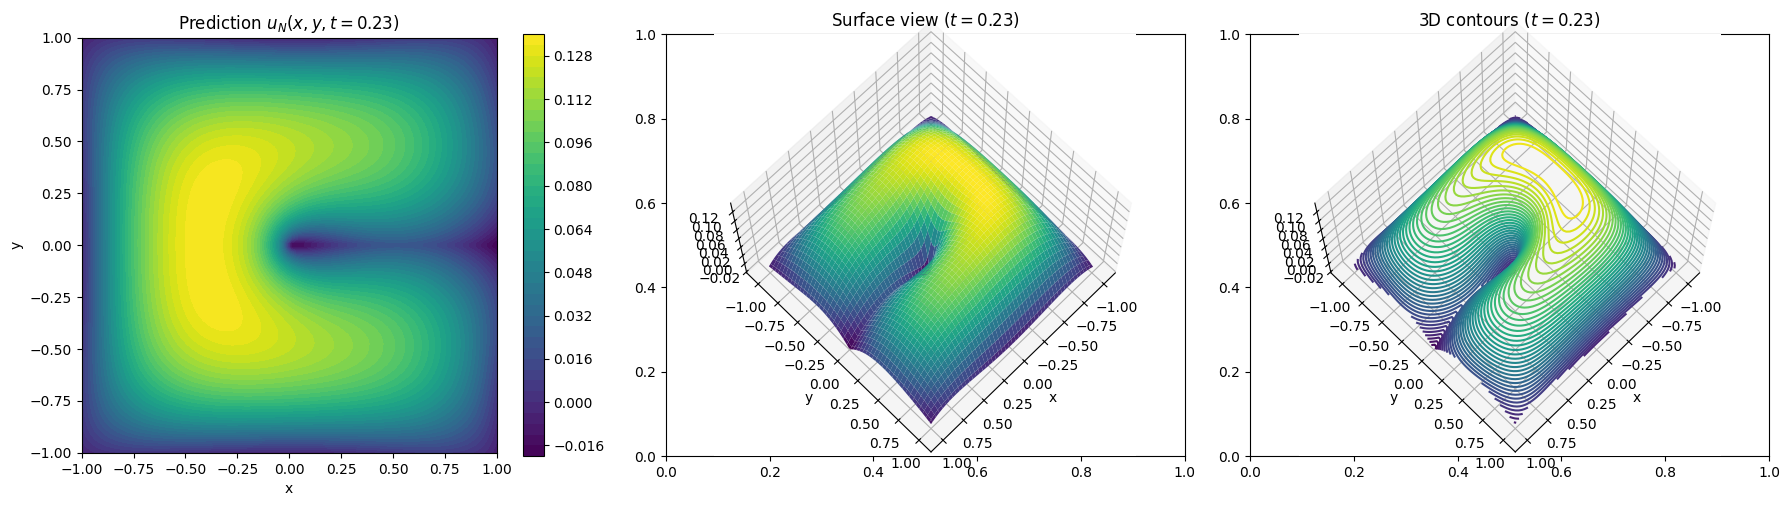

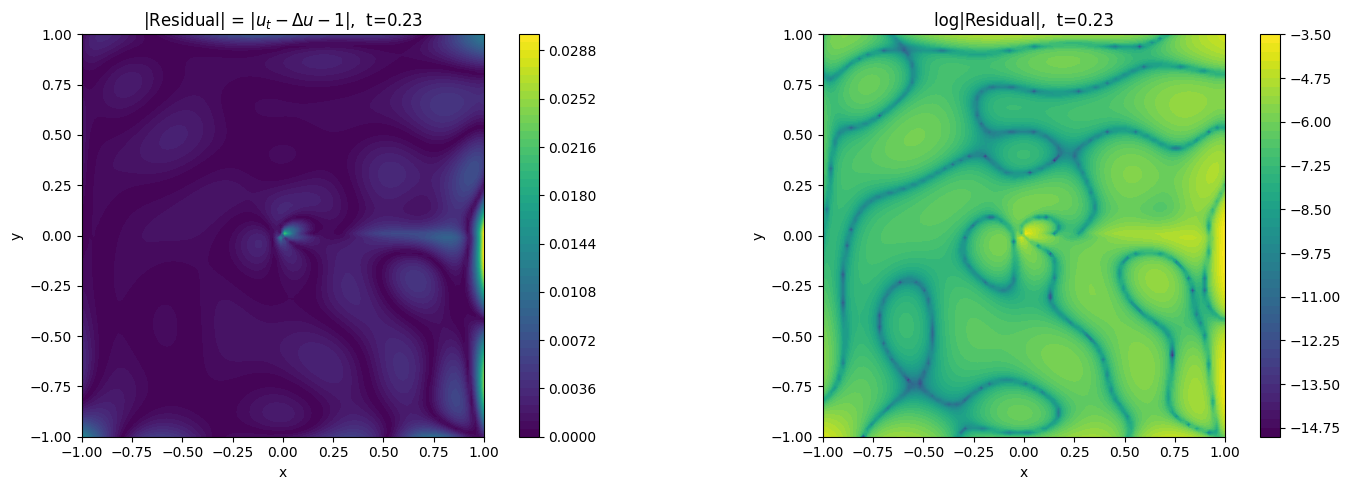

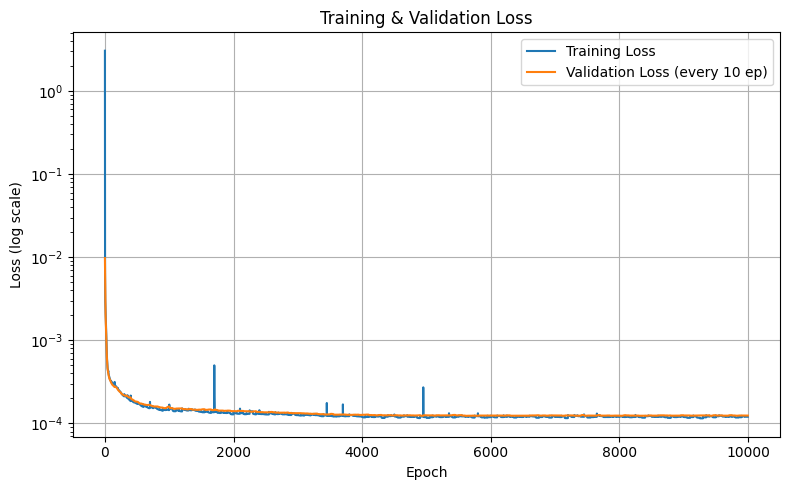

In [43]:
# test 
t0 = 0.23
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)

x_grid = torch.from_numpy(Xg.flatten()[:,None]).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).double()
t_grid = torch.full_like(x_grid, t0)  # 全部時間都固定為 t0

with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid, t_grid)


# 預測 u
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
    u_pred = model(inp_grid)
    U_pred = u_pred.cpu().numpy().reshape(nx, nx)


fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, U_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'Prediction $u_N(x,y,t={t0:.2f})$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(Xg, Yg, U_pred, cmap='viridis', edgecolor='none')
ax1.set_title(f'Surface view ($t={t0:.2f}$)')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.view_init(elev=70, azim=45)

ax2 = fig.add_subplot(133, projection='3d')
ax2.contour3D(Xg, Yg, U_pred, 50, cmap='viridis')
ax2.set_title(f'3D contours ($t={t0:.2f}$)')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.view_init(elev=70, azim=45)

plt.tight_layout()
plt.show()

# 殘差圖 
res, _, _, _, _ = compute_residual_time(model, x_grid, y_grid, t_grid)
abs_residual = torch.abs(res).detach().cpu().numpy().reshape(nx, nx)
log_abs_residual = np.log(abs_residual + 1e-12)  


fig, axs = plt.subplots(1, 2, figsize=(15,5))
im0 = axs[0].contourf(Xg, Yg, abs_residual, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'|Residual| = |$u_t - \\Delta u - 1$|,  t={t0:.2f}')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[0].set_aspect('equal')

im1 = axs[1].contourf(Xg, Yg, log_abs_residual, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title(f'log|Residual|,  t={t0:.2f}')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# loss 
epochs_arr = np.arange(len(loss_history))
val_epochs = np.linspace(0, len(loss_history)-1, len(val_history))
plt.figure(figsize=(8,5))
plt.semilogy(epochs_arr, loss_history, label='Training Loss')
plt.semilogy(val_epochs, val_history, label='Validation Loss (every 10 ep)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()